In [1]:
import csv
import tensorflow as tf
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional
from keras.callbacks import ModelCheckpoint


import nltk


print(tf.__version__)

2.10.0


In [2]:
def lempel_ziv_complexity(binary_sequence):
    """Lempel-Ziv complexity for a binary sequence, in simple Python code."""
    u, v, w = 0, 1, 1
    v_max = 1
    length = len(binary_sequence)
    complexity = 1
    while True:
        if binary_sequence[u + v - 1] == binary_sequence[w + v - 1]:
            v += 1
            if w + v >= length:
                complexity += 1
                break
        else:
            if v > v_max:
                v_max = v
            u += 1
            if u == w:
                complexity += 1
                w += v_max
                if w > length:
                    break
                else:
                    u = 0
                    v = 1
                    v_max = 1
            else:
                v = 1
    return complexity


In [3]:
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

vocab_size = 5000 
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '' #OOV = Out of Vocabulary
training_portion = .8

articles = []
labels = []

with open("/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)
print(len(labels))
print(len(articles))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Siana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2225
2225


In [4]:
labels[:2]

articles[:2]

train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

print("train_size",  train_size)
print(f"train_articles {len(train_articles)}")
print("train_labels", len(train_labels))
print("validation_articles", len(validation_articles))
print("validation_labels", len(validation_labels))

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_articles)

print(train_sequences[10]), len(train_sequences[10])

print(train_sequences[0]), len(train_sequences[0])

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

train_padded[10]



print("len train_sequnces[0]: ", len(train_sequences[0]))
print("len train_padded[0]: ", len(train_padded[0]))

print("len train_sequences[1]: ", len(train_sequences[1]))
print("len train_padded[1]: ", len(train_padded[1]))

print("len train_sequences[10]: ", len(train_sequences[10]))
print("len train_padded[10]: ", len(train_padded[10]))

train_size 1780
train_articles 1780
train_labels 1780
validation_articles 445
validation_labels 445
[2432, 1, 225, 4994, 22, 641, 586, 225, 4994, 1, 1, 1663, 1, 1, 2432, 22, 564, 1, 1, 140, 278, 1, 140, 278, 796, 823, 662, 2308, 1, 1144, 1694, 1, 1721, 4995, 1, 1, 1, 1, 1, 4737, 1, 1, 122, 4513, 1, 2, 2875, 1506, 352, 4738, 1, 52, 341, 1, 352, 2172, 3961, 41, 22, 3794, 1, 1, 1, 1, 542, 1, 1, 1, 835, 631, 2367, 347, 4739, 1, 365, 22, 1, 787, 2368, 1, 4301, 138, 10, 1, 3665, 682, 3531, 1, 22, 1, 414, 823, 662, 1, 90, 13, 633, 1, 225, 4994, 1, 600, 1, 1694, 1021, 1, 4996, 808, 1864, 117, 1, 1, 1, 2975, 22, 1, 99, 278, 1, 1609, 4997, 542, 492, 1, 1444, 4740, 778, 1320, 1, 1861, 10, 33, 641, 319, 1, 62, 478, 564, 301, 1507, 22, 479, 1, 1, 1666, 1, 797, 1, 3067, 1, 1365, 6, 1, 2432, 564, 22, 2972, 4734, 1, 1, 1, 1, 1, 850, 39, 1825, 675, 297, 26, 979, 1, 882, 22, 361, 22, 13, 301, 1507, 1343, 374, 20, 63, 883, 1096, 4302, 247]
[91, 160, 1141, 1106, 49, 979, 755, 1, 89, 1303, 4288, 129, 175, 

In [5]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

print(set(labels))


label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

label_tokenizer.word_index


print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)
print('-------------')
print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

model = Sequential()

model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(embedding_dim)))
model.add(Dense(6, activation='softmax'))

model.summary()

epochs = 50
learning_rate = 0.001
decay_rate = learning_rate / epochs
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=1e-6)


model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

445
(445, 200)
{'sport', 'entertainment', 'politics', 'tech', 'business'}
[4]
[2]
[1]
(1780, 1)
-------------
[5]
[4]
[3]
(445, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 386,822
Trainable params: 386,822
Non-trainable params: 0
___________________________________________________

In [6]:
output_layers = []
complexities = []

def get_output_layer(epoch, logs):
    output_layer = model.layers[2].output # index 2 corresponds to the LSTM layer
    intermediate_layer_model = tf.keras.models.Model(inputs=model.input, outputs=output_layer)
    intermediate_output = intermediate_layer_model.predict(train_padded)
    binary_output = (intermediate_output > 0.5).astype(int) # Convert to binary
    complexity = lempel_ziv_complexity(binary_output[0]) # Calculate complexity
    complexities.append(complexity)


# callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=get_output_layer)

num_epochs = 10



# model.fit(train_padded, train_labels, epochs=10, batch_size=32, callbacks=[tf.keras.callbacks.LambdaCallback(on_epoch_end=get_output_layer)])

history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), callbacks=[tf.keras.callbacks.LambdaCallback(on_epoch_end=get_output_layer)])

print("outputlayer is" , output_layers)

Epoch 1/10
56/56 [==============================] - 48s 600ms/step - loss: 1.5750 - accuracy: 0.2815 - val_loss: 1.3787 - val_accuracy: 0.5169
Epoch 2/10
56/56 [==============================] - 27s 493ms/step - loss: 1.2995 - accuracy: 0.4657 - val_loss: 1.1730 - val_accuracy: 0.6539
Epoch 3/10
56/56 [==============================] - 20s 360ms/step - loss: 0.7354 - accuracy: 0.7562 - val_loss: 0.7349 - val_accuracy: 0.7034
Epoch 4/10
56/56 [==============================] - 23s 411ms/step - loss: 0.2887 - accuracy: 0.9275 - val_loss: 0.3088 - val_accuracy: 0.8944
Epoch 5/10
56/56 [==============================] - 28s 509ms/step - loss: 0.1330 - accuracy: 0.9719 - val_loss: 0.6741 - val_accuracy: 0.8135
Epoch 6/10
56/56 [==============================] - 27s 483ms/step - loss: 0.1833 - accuracy: 0.9573 - val_loss: 0.2891 - val_accuracy: 0.9236
Epoch 7/10
56/56 [==============================] - 46s 826ms/step - loss: 0.0832 - accuracy: 0.9843 - val_loss: 0.2284 - val_accuracy: 0.9461

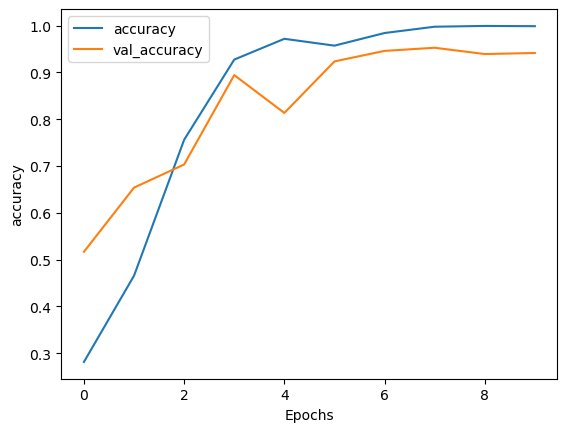

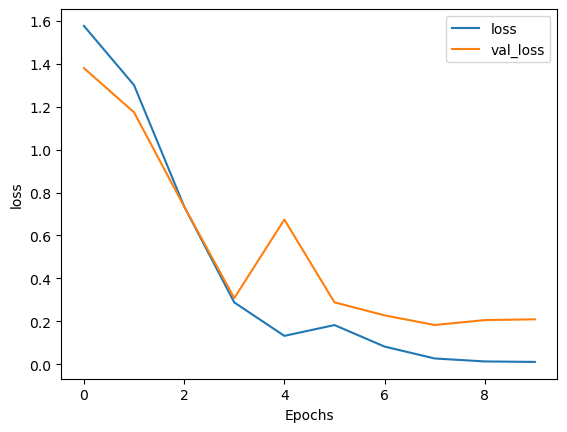

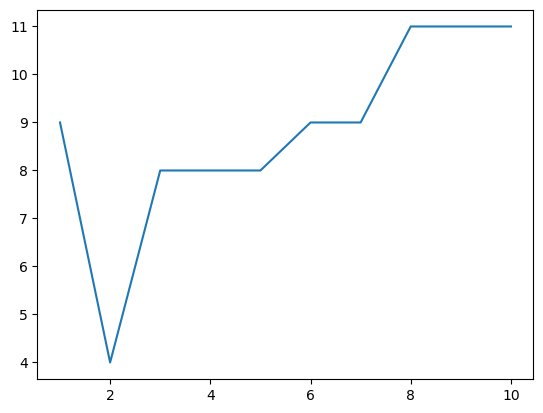

In [7]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

plt.plot(range(1, len(complexities)+1), complexities)
plt.savefig("/plot.png")
plt.show()

In [8]:
txt = ["house prices show slight increase prices of homes in the uk rose a seasonally adjusted 0.5% in february  says the nationwide building society.  the figure means the annual rate of increase in the uk is down to 10.2%  the lowest rate since june 2001. the annual rate has halved since august last year  as interest rises have cooled the housing market. at the same time  the number of mortgage approvals fell in january to a near 10-year low  official bank of england figures have shown.  nationwide said that in january house prices went up by 0.4% on the month and by 12.6% on a year earlier.  we are not seeing the market collapsing in the way some had feared   said nationwide economist alex bannister. there have been a number of warnings that the uk housing market may be heading for a downturn after four years of strong growth to 2004. in november  barclays  which owns former building society the woolwich  forecast an 8% fall in property prices in 2005  followed by further declines in 2006 and 2007. and last summer  economists at pricewaterhousecoopers (pwc) warned house prices were overvalued and could fall by between 10% and 15% by 2009.  the price of an average uk property now stands at £152 879. homeowners now expect house prices to rise by 1% over the next six months  mr bannister said. he said if the growth continued at this level then the bank of england may increase interest rates from their current 4.75%.   i think the key is what the bank expects to happen to the housing market. we always thought we would see a small rise  they thought they would see a small decline.  house prices have risen 0.9% this year  nationwide said  and if this pace of increase persists  prices would rise by just under 6% in the year to december. this is slightly above the 0-5% range nationwide predicts.  further evidence of a slowdown in the housing market emerged from bank of england lending figures released on tuesday. new mortgage loans in january fell to 79 000 from 82 000 in december  the bank said. the past few months have seen approvals fall to levels last seen in 1995. the bank revealed that 48 000 fewer mortgages were approved in january than for the same month in 2004. overall  mortgage lending rose by £7.2bn in january  marginally up on the £7.1bn rise in december."]

seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['sport', 'business', 'politics', 'tech', 'entertainment'] #orig

print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred)-1])

1/1 [==============================] - 2s 2s/step
[[6.6277200e-05 1.3462488e-03 9.9289131e-01 4.6449545e-04 2.7327696e-03
  2.4989746e-03]]
2
business


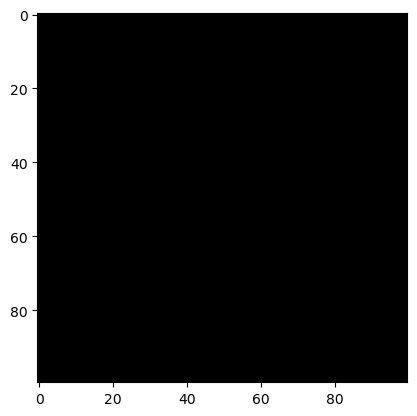

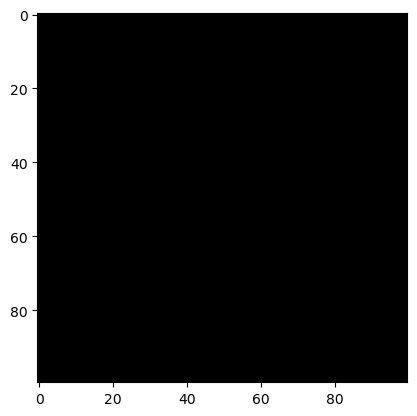

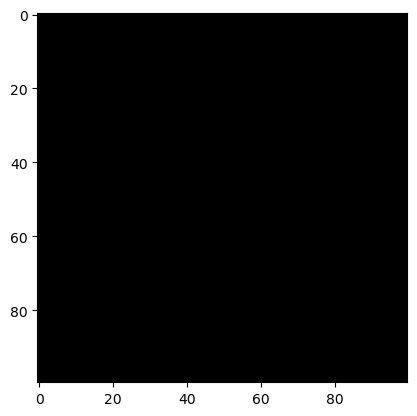

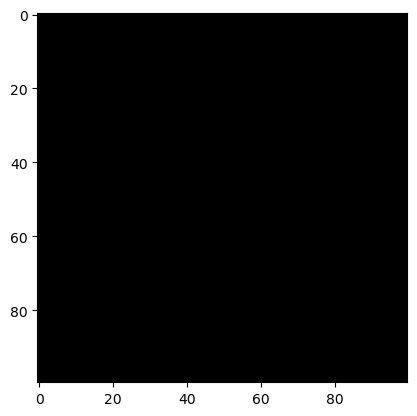

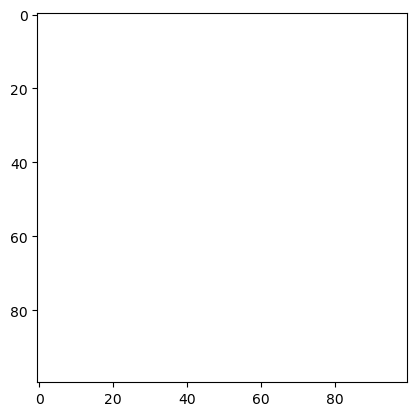

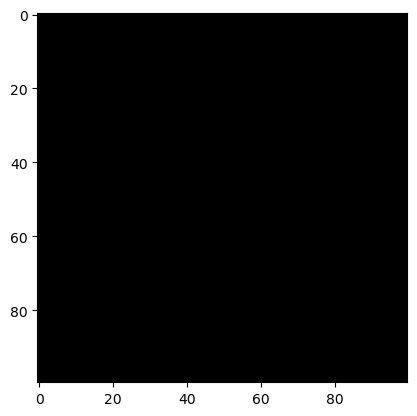

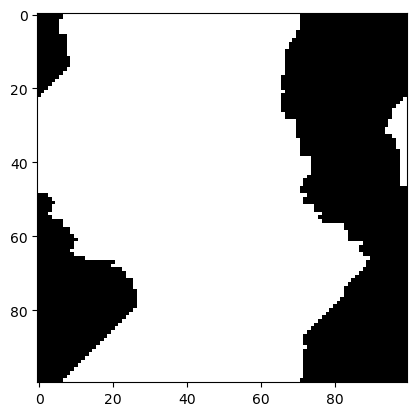

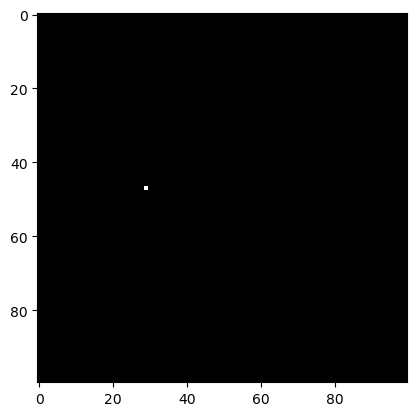

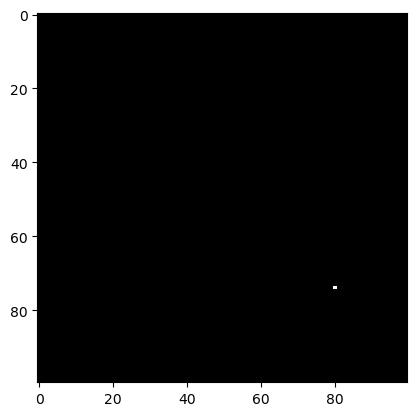

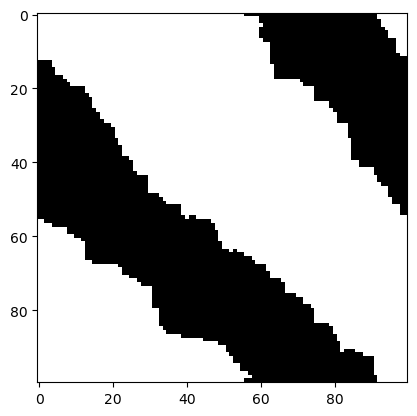

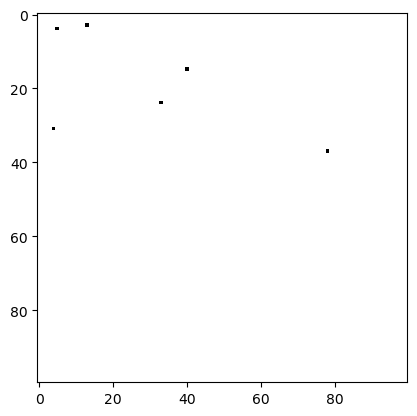

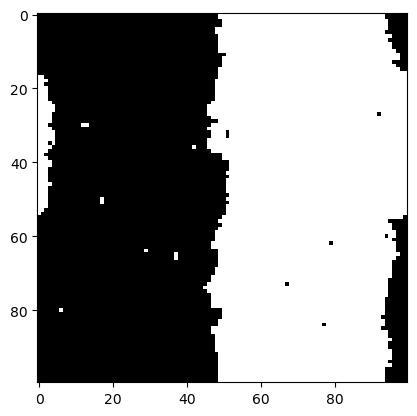

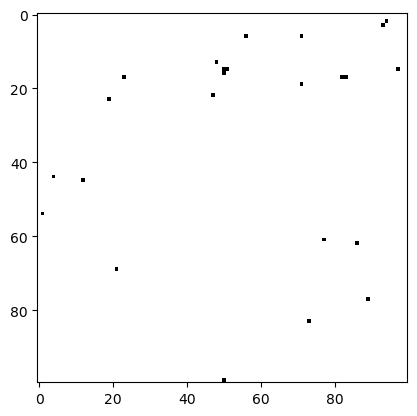

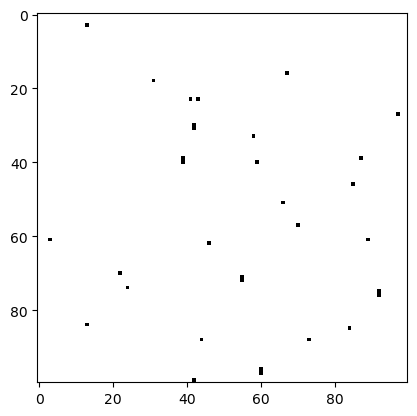

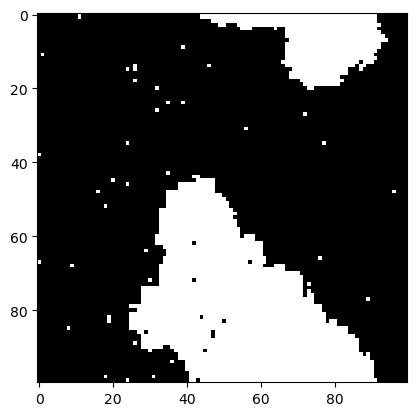

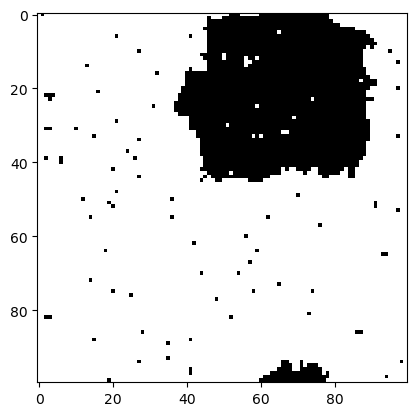

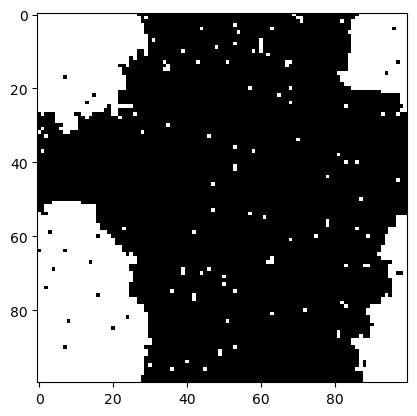

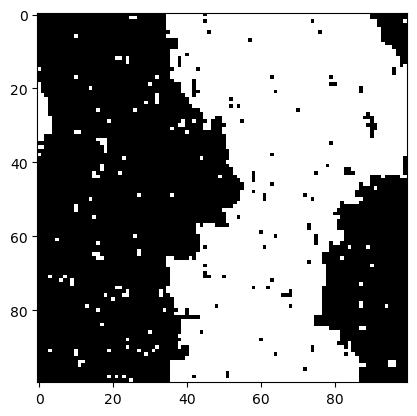

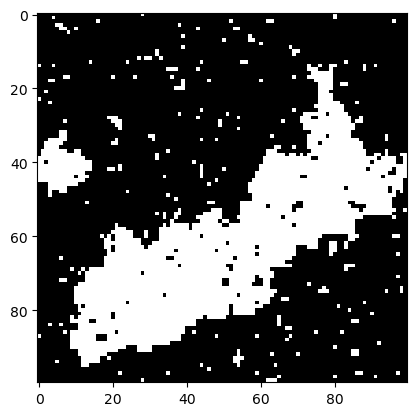

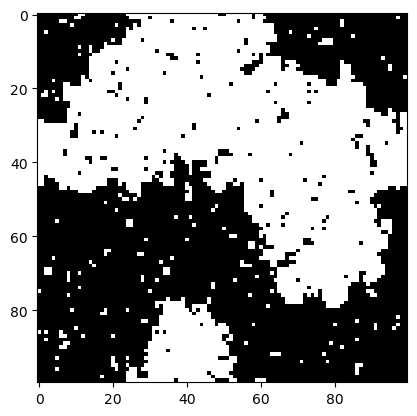

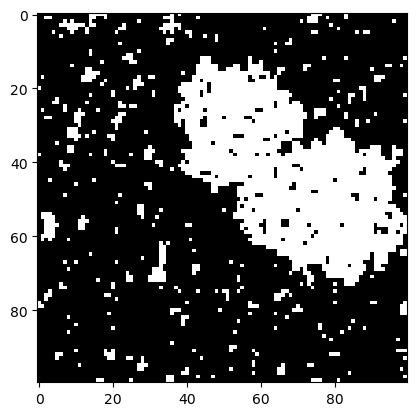

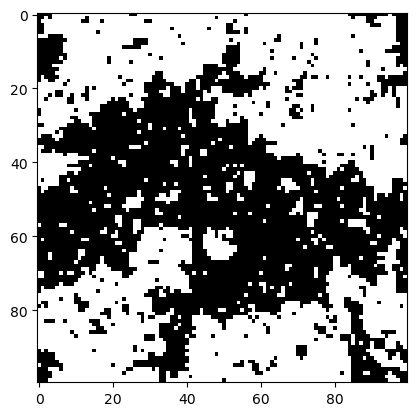

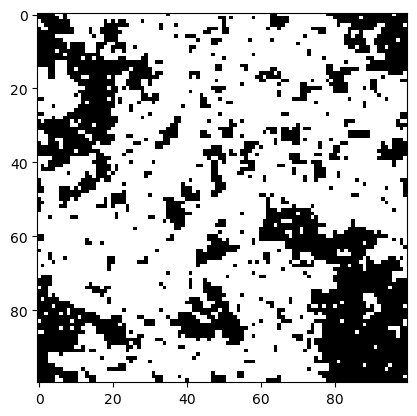

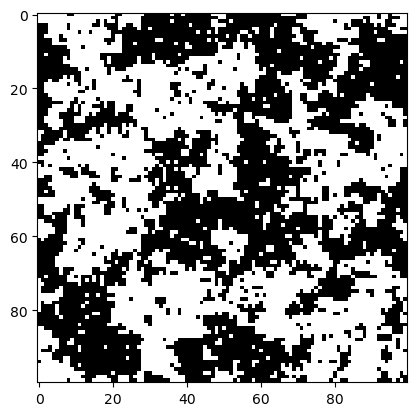

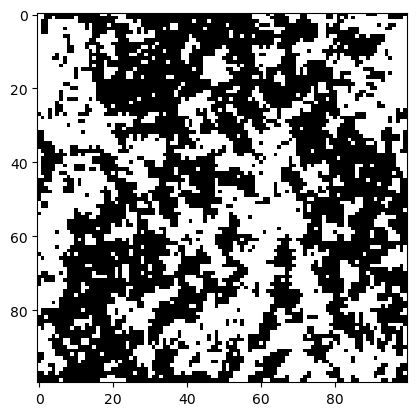

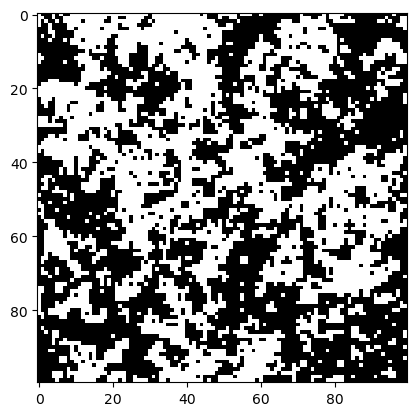

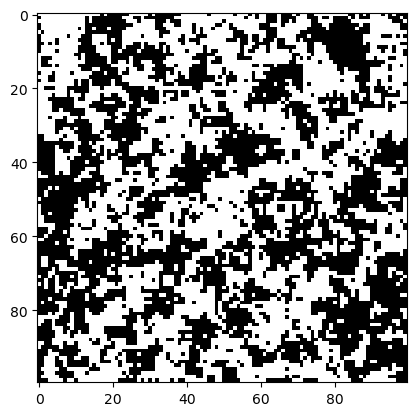

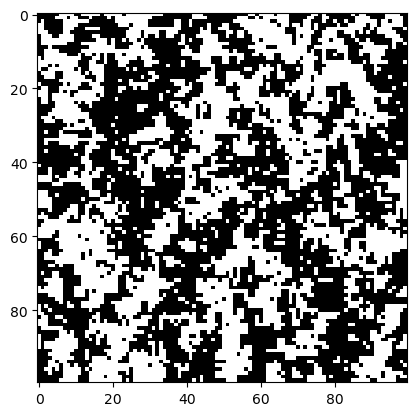

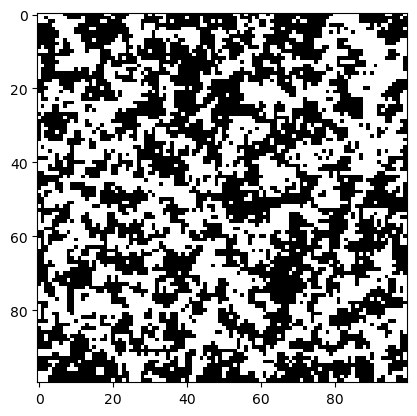

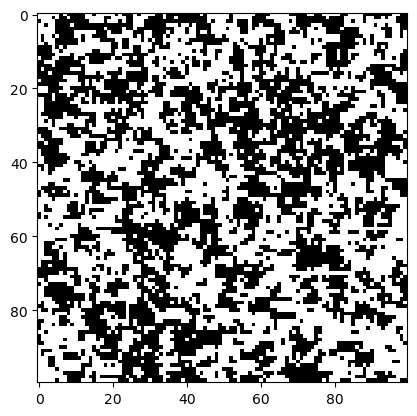

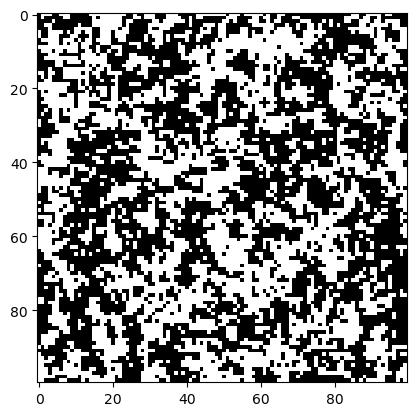

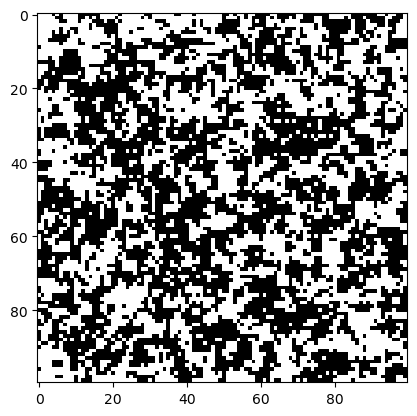

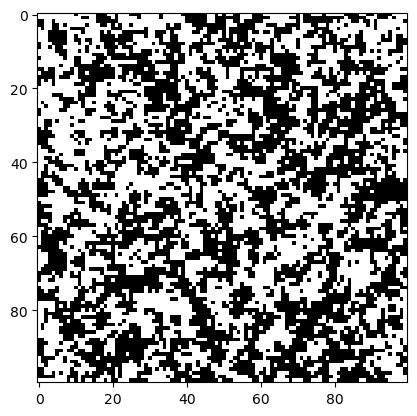

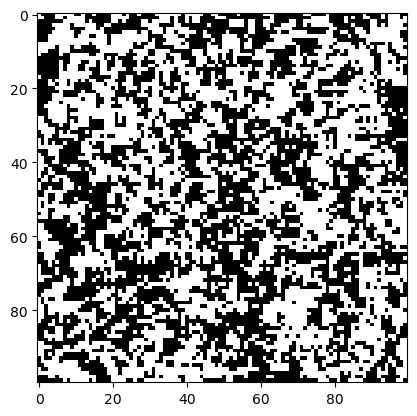

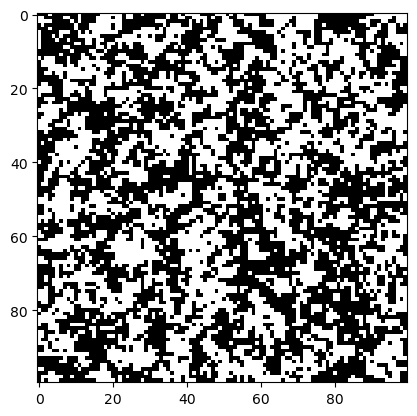

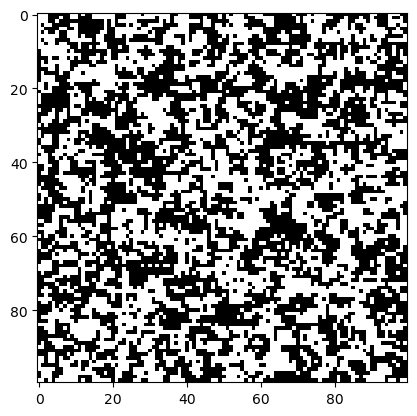

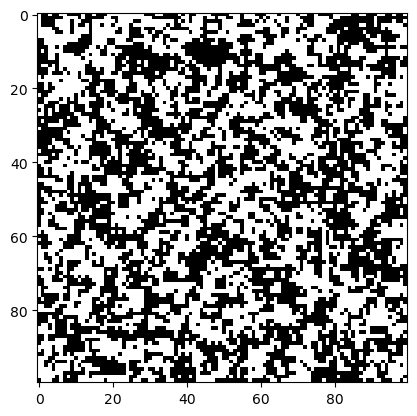

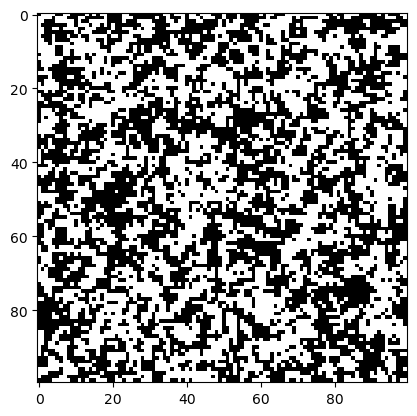

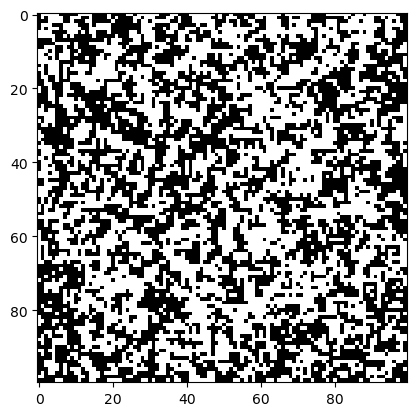

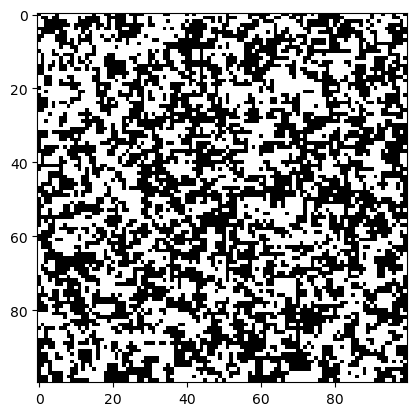

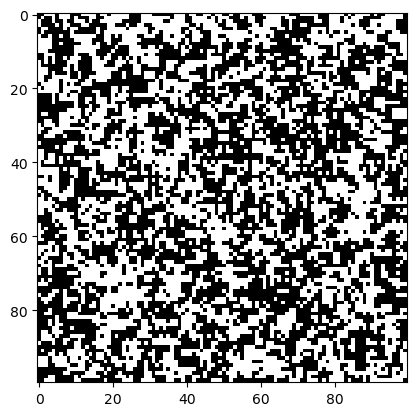

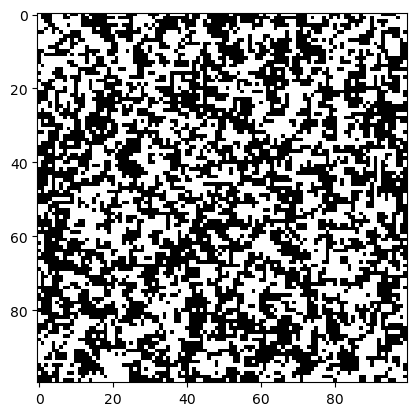

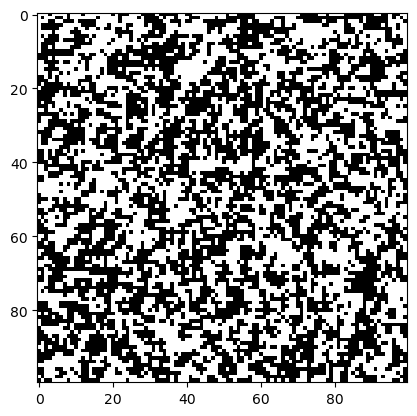

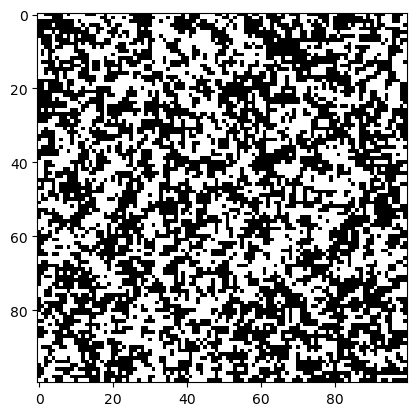

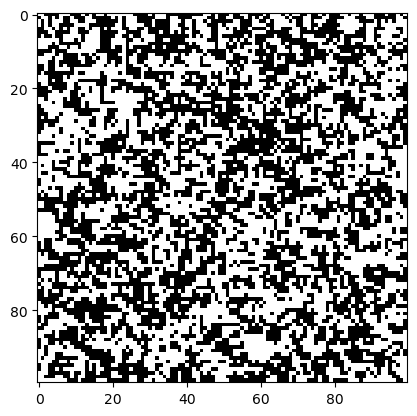

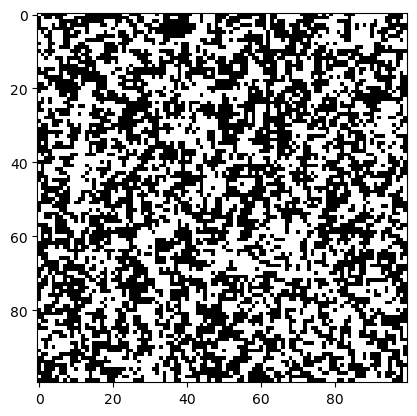

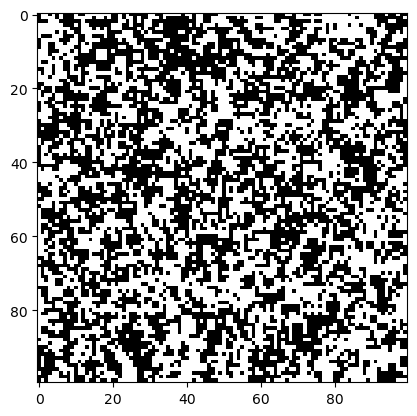

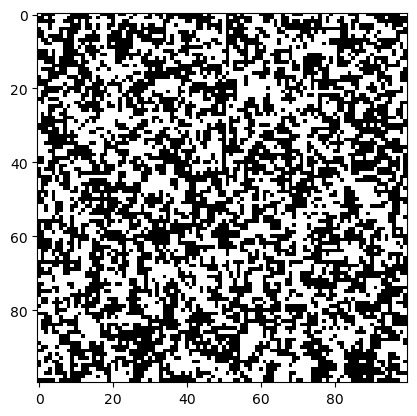

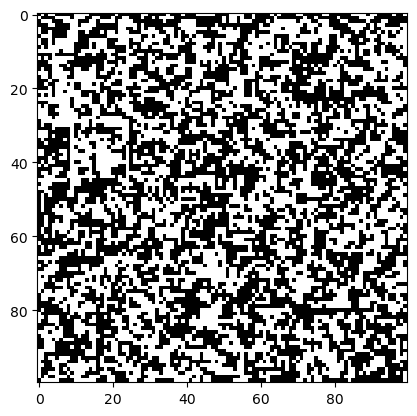

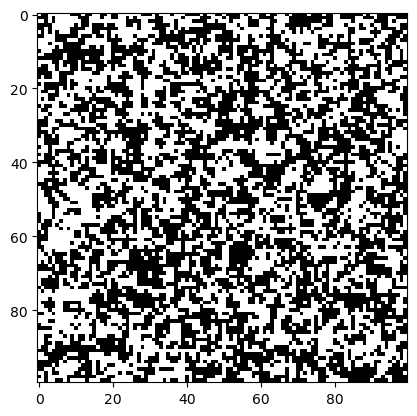

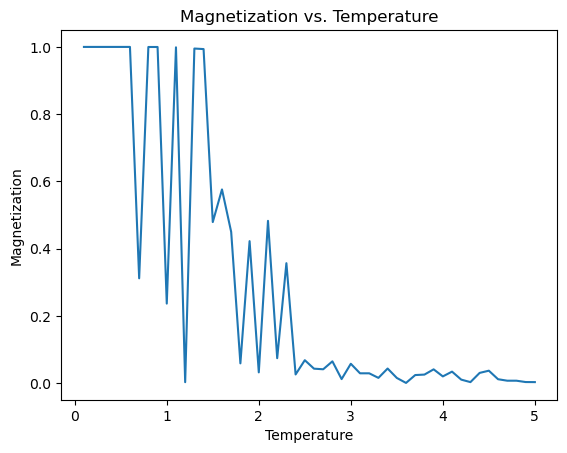

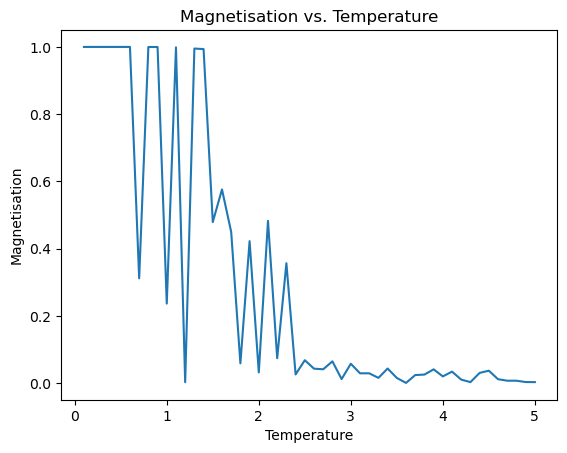

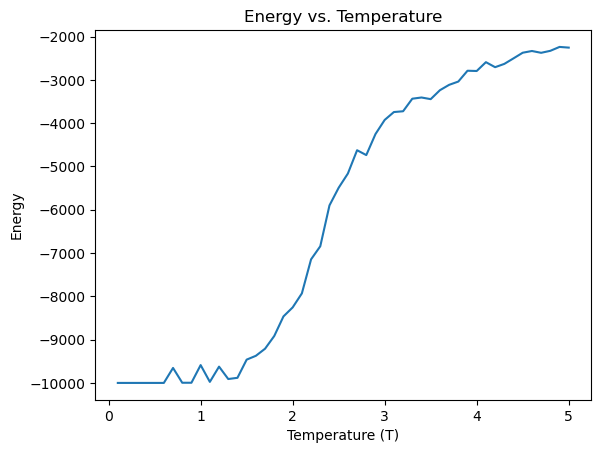

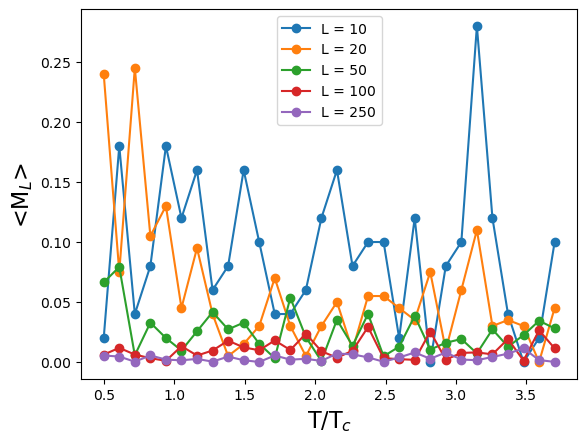

In [17]:
"""
In a synchronous update, all spins are updated simultaneously in one step, so the energy function and 
the Metropolis update are applied to all spins in the same way at each step. 
The result is a new configuration of spins that represents the next state of the system. 
This process is repeated multiple times to simulate the evolution of the system over time.
"""

def initialize_spin_matrix(N, M):
    return np.random.choice([-1, 1], size=(N, M))

def calculate_energy(spin_matrix, N, M, J):
    total_energy = 0
    for i in range(N):
        for j in range(M):
            total_energy += spin_matrix[i, j] * (
                spin_matrix[(i + 1) % N, j] +
                spin_matrix[i, (j + 1) % M]
            )
    return -J * total_energy/2

def calculate_magnetization(spin_matrix):
    return np.abs(np.sum(spin_matrix)/(N*M))

def convert_to_binary(spin_matrix):
    binary_spin_matrix = np.where(spin_matrix == -1, 0, 1)
    return binary_spin_matrix

def ising_model(N, M, T, J, n_steps):
    spin_matrix = initialize_spin_matrix(N, M)
    energies = []
    temperatures = []
    # magnetizations =[]
    for step in range(n_steps):
        old_spin_matrix = spin_matrix
        for i in range(N):
            for j in range(M):
                delta_E = 2 * J * old_spin_matrix[i, j] * (
                    old_spin_matrix[(i + 1) % N, j] +
                    old_spin_matrix[i, (j + 1) % M] +
                    old_spin_matrix[(i - 1 + N) % N, j] +
                    old_spin_matrix[i, (j - 1 + M) % M]
                )
                beta = 1 / T
                if np.random.uniform() < np.exp(-beta * delta_E):
                    spin_matrix[i, j] *= -1
        energies.append(calculate_energy(spin_matrix, N, M, J))
        # magnetizations.append(calculate_magnetization(spin_matrix))

        temperatures.append(T)
    binary_spin_matrix = convert_to_binary(spin_matrix)
    # filename = f"./ising_model_data/spin_matrix_T{T}.txt"
    # np.savetxt(filename, binary_spin_matrix, fmt='%d')
    return energies, temperatures, spin_matrix


# def ising_model(N, M, T, J, n_steps):
#     spin_matrix = initialize_spin_matrix(N, M)
#     energies = []
#     spins = []
#     for step in range(n_steps):
#         old_spin_matrix = spin_matrix
#         for i in range(N):
#             for j in range(M):
#                 delta_E = 2 * J * old_spin_matrix[i, j] * (
#                     old_spin_matrix[(i + 1) % N, j] +
#                     old_spin_matrix[i, (j + 1) % M] +
#                     old_spin_matrix[(i - 1 + N) % N, j] +
#                     old_spin_matrix[i, (j - 1 + M) % M]
#                 )
#                 beta = 1 / T
#                 if np.random.uniform() < np.exp(-beta * delta_E):
#                     spin_matrix[i, j] *= -1
#         energies.append(calculate_energy(spin_matrix, N, M, J))
#         spins.append(np.sum(spin_matrix)/(N*M))
        
#     binary_spin_matrix = convert_to_binary(spin_matrix)
#     filename = f"./ising_model_data/spin_matrix_T{T}.txt"
#     np.savetxt(filename, binary_spin_matrix, fmt='%d')
    
#     return spin_matrix, energies, spins

N = 100
M = 100

temp = np.arange(0.1, 5.1, 0.1)
T_list = np.round(temp,2)

# T_list = [0.5, 1.0, 2.0,2.2,2.27, 2.3, 2.4, 2.5, 2.6,3.5, 5.0]
J = 1
n_steps = 100

magnetizations = []
energies1 =[]
for T in T_list:
    energies, temperatures, spin_matrix = ising_model(N, M, T, J, n_steps)
    energie1 = calculate_energy(spin_matrix, N, M, J)
    energies1.append(energie1)
    magnetization = calculate_magnetization(spin_matrix)
    magnetizations.append(magnetization)

    plt.clf()
    plt.imshow(spin_matrix, cmap='gray', vmin=0, vmax=1)
    # plt.title("Final state of spin matrix for T = {}".format(T))
    # plt.savefig("./im_plots/im_step{}.png".format(T))
    plt.show()

    # plt.clf()
    # plt.plot(energies)
    # plt.xlabel("Step")
    # plt.ylabel("Energy")
    # plt.title("Energy vs. Step for T = {}".format(T))
    # plt.savefig("./ising_model_plots/im_temp{}.png".format(T))
    # #plt.show()

# temperatures = [0.5, 2.27, 5.0]

# for T in temperatures:
#     spin_matrix, energies, spins = ising_model(N=50, M=50, T=T, J=1, n_steps=1000)
#     plt.plot(range(len(spins)), spins, label = 'T = {0}'.format(T))
    
# plt.legend(loc = 'best')
# plt.xlabel('nSteps')
# plt.ylabel('Average Spin')
# plt.ylim(-1.2, 1.2)
# plt.savefig('./im_plots/average-spin.png')
# plt.show()

# for T in T_list:
#     energies, temperatures, spin_matrix = ising_model(N, M, T, J, n_steps)
#     magnetization = calculate_magnetization(spin_matrix)
#     magnetizations.append(magnetization)

plt.clf()
plt.plot(T_list, magnetizations)
plt.xlabel("Temperature")
plt.ylabel("Magnetization")
plt.title("Magnetization vs. Temperature")
# plt.savefig("im_plots/ex_mag.png")
plt.show()

plt.clf()
plt.plot(T_list, magnetizations)
plt.xlabel("Temperature")
plt.ylabel("Magnetisation")
plt.title("Magnetisation vs. Temperature")
# plt.savefig("./im_plots/im_mag_abs.png")
plt.show()

plt.clf()
plt.plot(T_list, energies1)
plt.xlabel("Temperature (T)")
plt.ylabel("Energy")
plt.title("Energy vs. Temperature")
# plt.savefig("./im_plots/im_energy_2.png")
plt.show()

Ns = [10, 20, 50, 100, 250]  # System Size
T_Tcs = np.linspace(0.5, 3.7, 30)  # T/Tc
Tc = 2.268  # Onsager's Tc

def ising_model_magnetization(n, t):
    spins = np.random.choice([-1, 1], size=(n, n))
    beta = 1 / (t * Tc)
    for i in range(5000):
        row, col = np.random.randint(n, size=2)
        energy_change = 2 * spins[row, col] * (spins[(row-1)%n, col] + spins[(row+1)%n, col] + spins[row, (col-1)%n] + spins[row, (col+1)%n])
        if energy_change < 0 or np.random.rand() < np.exp(-beta * energy_change):
            spins[row, col] *= -1
    return np.abs(np.sum(spins)) / n**2

for n in Ns:
    avgspins = []
    for i, T_Tc in enumerate(T_Tcs):
        T = T_Tc * Tc
        avgspin = ising_model_magnetization(n, T)
        avgspins.append(avgspin)
    plt.plot(T_Tcs, avgspins, 'o-', label='L = {0}'.format(n))

plt.xlabel('T/T$_{c}$', fontsize=16)
plt.ylabel('<M$_{L}$>', fontsize=16)
plt.legend()
# plt.savefig('im_plots/magnetization19.png')
plt.show()